<a href="https://colab.research.google.com/github/filmerxyz/Skin_Detection/blob/master/NASNetMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [6]:
!pip install tensorflow-gpu==1.15
!pip install split-folders
!pip install Augmentor

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 438, in run
    self._warn_about_conflicts(to_install)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 568, in _warn_about_conflicts
    package_set, _dep_info = check_install_conflicts(to_install)
  File "/usr/local/lib/python3.6/

In [ ]:
import tensorflow as tf

In [8]:
print(tf.__version__)

1.15.0


# Import Libraries

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras.applications.nasnet import decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.framework import ops

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import itertools

import split_folders
import Augmentor

import numpy as np
import matplotlib.pyplot as plt

import cv2

import os
from os.path import join
import glob
import shutil
import random

import json
from IPython.display import Image, display

import utils_functions
from utils_functions import mkdir_dir, plotImages, plot_confusion_matrix, load_image, deprocess_image, normalize, decode_predictions, guided_backprop, grad_cam, grad_cam_batch, compute_saliency # build_guided_model, 

# Clone Data

In [10]:
!git clone https://github.com/filmerxyz/SKIN_DATA

Cloning into 'SKIN_DATA'...
remote: Enumerating objects: 679, done.
remote: Counting objects: 100% (679/679), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 1121 (delta 267), reused 565 (delta 156), pack-reused 442
Receiving objects: 100% (1121/1121), 127.74 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (305/305), done.


# Define Functions

**Plot Images**

In [ ]:
def plot_all_img_dir(directory):
  all_img_list = []
  for img in glob.glob(directory):
    img_array = cv2.imread(img)
    all_img_list.append(img_array)

  plt.figure(figsize=(10,10))
  columns = 5
  for i, image in enumerate(all_img_list):
      plt.subplot(len(all_img_list) / columns + 1, columns, i + 1)
      plt.imshow(image)

**Grad CAM** 

In [ ]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = model
    return new_model

# Make a Folder

In [13]:
mkdir_dir('/content/data_folder')

Directory  /content/data_folder  Created 


# Split Data

In [14]:
split_folders.ratio('/content/SKIN_DATA/crop_classes_data', 
                    output='/content/data_folder', 
                    seed=1337, 
                    ratio=(0.8, 0.1, 0.1)) #train=0.8, val=0.1, test=0.1

Copying files: 224 files [00:00, 1673.55 files/s]


# Directories

In [ ]:
train_dir = '/content/data_folder/train'
val_dir = '/content/data_folder/val'
test_dir = '/content/data_folder/test'

# Data Visualization

In [ ]:
ad_dir = '/content/data_folder/train/AtopicDermatitis'
pv_dir = '/content/data_folder/train/PsoriasisVulgaris'
sk_dir = '/content/data_folder/train/SeborrhoeicKeratosis'
vt_dir = '/content/data_folder/train/Vitiligo'

In [ ]:
# plotImages(val_dir[:5])

# Parameters

In [ ]:
img_width = 224
img_height = 224
epochs = 100
batch_size = 32

# Data Augmentation

In [ ]:
root_directory = '/content/data_folder/train/*'

In [20]:
folders = []
for f in glob.glob(root_directory):
    if os.path.isdir(f):
        folders.append(os.path.abspath(f))

print("Folders (classes) found: %s " % [os.path.split(x)[1] for x in folders])

Folders (classes) found: ['SeborrhoeicKeratosis', 'AtopicDermatitis', 'Vitiligo', 'PsoriasisVulgaris'] 


In [21]:
pipelines = {}
for folder in folders:
    print("Folder %s:" % (folder))
    pipelines[os.path.split(folder)[1]] = (Augmentor.Pipeline(folder))
    print("\n----------------------------\n")

Folder /content/data_folder/train/SeborrhoeicKeratosis:
Initialised with 45 image(s) found.
Output directory set to /content/data_folder/train/SeborrhoeicKeratosis/output.
----------------------------

Folder /content/data_folder/train/AtopicDermatitis:
Initialised with 52 image(s) found.
Output directory set to /content/data_folder/train/AtopicDermatitis/output.
----------------------------

Folder /content/data_folder/train/Vitiligo:
Initialised with 19 image(s) found.
Output directory set to /content/data_folder/train/Vitiligo/output.
----------------------------

Folder /content/data_folder/train/PsoriasisVulgaris:
Initialised with 62 image(s) found.
Output directory set to /content/data_folder/train/PsoriasisVulgaris/output.
----------------------------



In [22]:
for p in pipelines.values():
    print("Class %s has %s samples." % (p.augmentor_images[0].class_label, len(p.augmentor_images)))

Class SeborrhoeicKeratosis has 45 samples.
Class AtopicDermatitis has 52 samples.
Class Vitiligo has 19 samples.
Class PsoriasisVulgaris has 62 samples.


In [23]:
for train_aug in pipelines.values():
    train_aug.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
    train_aug.flip_left_right(probability=0.5)
    train_aug.flip_top_bottom(probability=0.5)
    train_aug.zoom_random(probability=0.5, percentage_area=0.8)
    #train_aug.status()
    train_aug.sample(300)

Processing <PIL.Image.Image image mode=RGB size=1366x1040 at 0x7FB401C2A2E8>: 100%|██████████| 300/300 [01:13<00:00,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=758x295 at 0x7FB401C1D358>: 100%|██████████| 300/300 [00:09<00:00, 32.25 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=450x267 at 0x7FB401C27390>: 100%|██████████| 300/300 [00:13<00:00, 23.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x410 at 0x7FB401C277B8>: 100%|██████████| 300/300 [00:13<00:00, 22.30 Samples/s]


# Rename Folders

In [ ]:
ad_aug_dir = os.rename('/content/data_folder/train/AtopicDermatitis/output', '/content/data_folder/train/AtopicDermatitis/ad_aug_dir')
pv_aug_dir = os.rename('/content/data_folder/train/PsoriasisVulgaris/output', '/content/data_folder/train/PsoriasisVulgaris/pv_aug_dir')
sk_aug_dir = os.rename('/content/data_folder/train/SeborrhoeicKeratosis/output', '/content/data_folder/train/SeborrhoeicKeratosis/sk_aug_dir')
vt_aug_dir = os.rename('/content/data_folder/train/Vitiligo/output', '/content/data_folder/train/Vitiligo/vt_aug_dir')

In [ ]:
ad_aug_dir = '/content/data_folder/train/AtopicDermatitis/ad_aug_dir'
pv_aug_dir = '/content/data_folder/train/PsoriasisVulgaris/pv_aug_dir'
sk_aug_dir = '/content/data_folder/train/SeborrhoeicKeratosis/sk_aug_dir'
vt_aug_dir = '/content/data_folder/train/Vitiligo/vt_aug_dir'

In [ ]:
# print(len(os.listdir(ad_aug_dir)))
# print(len(os.listdir(pv_aug_dir)))
# print(len(os.listdir(sk_aug_dir)))
# print(len(os.listdir(vt_aug_dir)))

In [27]:
mkdir_dir('/content/data_folder/train_aug')

Directory  /content/data_folder/train_aug  Created 


In [ ]:
train_aug_dir = '/content/data_folder/train_aug/'

In [29]:
shutil.move(ad_aug_dir, train_aug_dir)
shutil.move(pv_aug_dir, train_aug_dir)
shutil.move(sk_aug_dir, train_aug_dir)
shutil.move(vt_aug_dir, train_aug_dir)

'/content/data_folder/train_aug/vt_aug_dir'

# Data Augmentation Visualization

In [ ]:
# plot_all_img_dir('/content/data_folder/train_aug/ad_aug_dir')
# plot_all_img_dir('/content/data_folder/train_aug/pv_aug_dir')

In [ ]:
train_gen = ImageDataGenerator(rescale=1. / 255)

val_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = ImageDataGenerator(rescale=1. / 255)

In [32]:
train_datagen = train_gen.flow_from_directory(batch_size=batch_size,
                                          directory=train_aug_dir,
                                          shuffle=True,
                                          target_size=(img_width, img_height), #(224,224)
                                          class_mode='categorical')
val_datagen = val_gen.flow_from_directory(batch_size=batch_size,
                                          directory=val_dir,
                                          shuffle=True,
                                          target_size=(img_width, img_height), #(224,224)
                                          class_mode='categorical')
test_datagen = test_gen.flow_from_directory(batch_size=batch_size,
                                          directory=test_dir,
                                          shuffle=False,
                                          target_size=(img_width, img_height), #(224,224)
                                          class_mode='categorical')

Found 1200 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Found 26 images belonging to 4 classes.


In [ ]:
# sample_training_images, _ = next(train_datagen)
# plotImages(sample_training_images[:5])

In [34]:
num_train_files = len(train_datagen.filenames)
num_train_classes = len(train_datagen.class_indices)
print('num_train_files', num_train_files, '&', 'num_train_classes', num_train_classes )

num_val_files = len(val_datagen.filenames)
num_val_classes = len(val_datagen.class_indices)
print('num_val_files', num_val_files, '&', 'num_val_classes', num_val_classes )

num_test_files = len(test_datagen.filenames)
num_test_classes = len(test_datagen.class_indices)
print('num_test_files', num_test_files, '&', 'num_test_classes', num_test_classes )

num_train_files 1200 & num_train_classes 4
num_val_files 20 & num_val_classes 4
num_test_files 26 & num_test_classes 4


In [ ]:
train_steps = np.ceil(num_train_files/batch_size)
val_steps = np.ceil(num_val_files/batch_size)

# Model


In [ ]:
def build_model():
  base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
  base_model.trainable = False
  # base_model.summary()
  # len(base_model.layers)
  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  prediction_layer = tf.keras.layers.Dense(units=4, activation='softmax', name='prediction')(average_pooling_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  # model.summary()
  # len(model.layers)
  return model

In [37]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
19996672/19993432 [==============================] - 3s 0us/step


# Compile

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
#                              save_best_only=True, mode='max')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
cb_list = [early_stop]

# Train

In [42]:
history = model.fit(train_datagen,
                    steps_per_epoch=train_steps,
                    validation_data=val_datagen,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=cb_list)

Epoch 1/100
38/38 [==============================] - 30s 792ms/step - loss: 1.1470 - acc: 0.5108 - val_loss: 1.0372 - val_acc: 0.6500
Epoch 2/100
38/38 [==============================] - 11s 277ms/step - loss: 0.6749 - acc: 0.7850 - val_loss: 0.9574 - val_acc: 0.5000
Epoch 3/100
38/38 [==============================] - 13s 334ms/step - loss: 0.5436 - acc: 0.8342 - val_loss: 0.9860 - val_acc: 0.4500
Epoch 4/100
38/38 [==============================] - 13s 343ms/step - loss: 0.4634 - acc: 0.8525 - val_loss: 1.0101 - val_acc: 0.5000
Epoch 5/100
38/38 [==============================] - 13s 337ms/step - loss: 0.3984 - acc: 0.8908 - val_loss: 0.9673 - val_acc: 0.5500
Epoch 6/100
38/38 [==============================] - 13s 339ms/step - loss: 0.3728 - acc: 0.8850 - val_loss: 0.9207 - val_acc: 0.6000
Epoch 7/100
38/38 [==============================] - 13s 339ms/step - loss: 0.3227 - acc: 0.9108 - val_loss: 1.0347 - val_acc: 0.7000
Epoch 8/100
38/38 [==============================] - 13s 339ms

# Graph

**Accuracy**

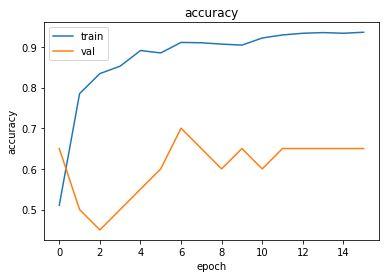

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

**Loss**

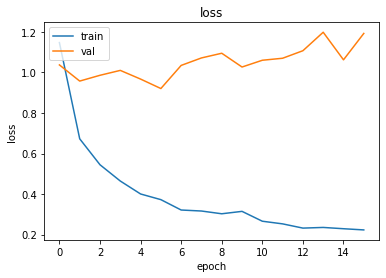

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Save Weights

In [ ]:
model.save_weights('/content/skin_weights.h5')

In [ ]:
skin_weights='/content/skin_weights.h5'

In [ ]:
model.load_weights(skin_weights)

In [48]:
test_labels = test_datagen.classes
predictions = model.predict_generator(test_datagen, steps=val_steps, verbose=1)

1/1 [==============================] - 6s 6s/step


# Confusion Matrix

Confusion matrix, without normalization
[[5 0 0 2]
 [6 1 0 2]
 [0 0 7 0]
 [2 0 0 1]]


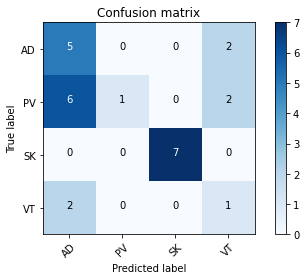

In [49]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['AD', 'PV', 'SK', 'VT']

plot_confusion_matrix(cm, cm_plot_labels)

# Classification Report

In [50]:
Y_pred = model.predict_generator(test_datagen, num_test_files//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_datagen.classes, y_pred))
print('Classification Report')
classes_names = ['AD', 'PV', 'SK', 'VT']
print(classification_report(test_datagen.classes, y_pred, target_names=classes_names))

Confusion Matrix
[[5 0 0 2]
 [6 1 0 2]
 [0 0 7 0]
 [2 0 0 1]]
Classification Report
              precision    recall  f1-score   support

          AD       0.38      0.71      0.50         7
          PV       1.00      0.11      0.20         9
          SK       1.00      1.00      1.00         7
          VT       0.20      0.33      0.25         3

    accuracy                           0.54        26
   macro avg       0.65      0.54      0.49        26
weighted avg       0.74      0.54      0.50        26



# Image

In [ ]:
image_dir = '/content/data_folder/val'
img_paths = [join(image_dir, filename) for filename in 
               ['SeborrhoeicKeratosis/dq013406HB.jpg',
                'SeborrhoeicKeratosis/dq014959HB.jpg']]


In [ ]:
def read_prep_images(img_paths, img_height=img_height, img_width=img_width):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return output

In [ ]:
test_data = read_prep_images(img_paths)

In [ ]:
preds = model.predict(test_data)

In [55]:
most_likely_labels = decode_predictions(preds, top=5, class_list_path='/content/SKIN_DATA/skin_index.json')

for i, img_path in enumerate(img_paths):
    # display(Image(img_path))
    print(most_likely_labels[i])

[('Psoriasis Vulgaris', 'PsoriasisVulgaris', 0.98181045), ('Atopic Dermatitis', 'AtopicDermatitis', 0.018165797), ('Seborrhoeic Keratosis', 'SeborrhoeicKeratosis', 2.3771256e-05), ('Vitiligo', 'Vitiligo', 3.2210927e-08)]
[('Psoriasis Vulgaris', 'PsoriasisVulgaris', 0.9986389), ('Atopic Dermatitis', 'AtopicDermatitis', 0.0013610583), ('Vitiligo', 'Vitiligo', 6.444173e-11), ('Seborrhoeic Keratosis', 'SeborrhoeicKeratosis', 2.8629104e-13)]


# Grad CAM

In [ ]:
# model = model
guided_model = build_guided_model()

In [ ]:
x_img = '/content/data_folder/test/AtopicDermatitis/close-image-patch-human-skin-260nw-638839474.jpg'

In [ ]:
# outputs = [layer.output for layer in model.layers[1:771]]

# layer_names = []
# for layer in outputs:
#     layer_names.append(layer.name.split("/")[0])

    
# print("Layers going to be used for visualization: ")
# print(layer_names)

Model prediction:
	AtopicDermatitis	(0)	with probability 0.814
	PsoriasisVulgaris	(1)	with probability 0.076
	Vitiligo       	(3)	with probability 0.073
	SeborrhoeicKeratosis	(2)	with probability 0.038
Explanation for 'AtopicDermatitis'


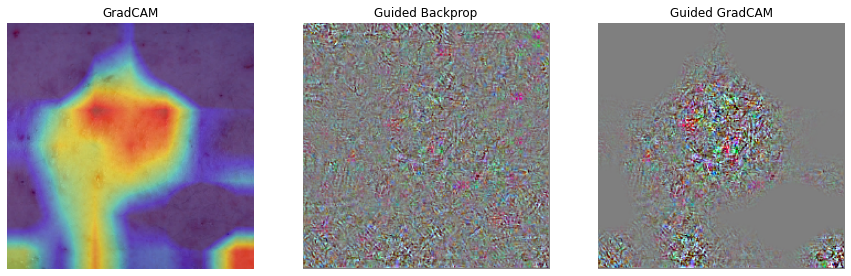

In [59]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, x_img, layer_name='normal_add_5_12', cls=-1, visualize=True, save=True)